Outlier_Filter

In [2]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
auto_position = widgets.Checkbox(value=False, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Users\lucio\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\lucio\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [3]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [4]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1), layout=Layout(width='600px'), options=('VA_007_fixture_da…

Table *VA_007_measurements_2023y_12m_21d_14h_05m_01s* retrieved succesfully.
Table *VA_007_limits_2023y_12m_21d_14h_05m_01s* retrieved succesfully.


RyR calculation

In [5]:
##RyR dataframe generation
RyR_df = RyR(pd.concat([MEAS, LIMITS], axis=1))
RyR_df_format = rename_index(RyR_df)
print("RyR")
RyR_df_format

RyR


,RyR,Status
Guia_Luz_Blanco_FB1_X,0.295872,Correct
Guia_Luz_Blanco_FB1_Y,0.285754,Correct
Guia_Luz_Blanco_FB2_X,0.360651,Correct
Guia_Luz_Blanco_FB2_Y,0.318112,Correct
Guia_Luz_Blanco_FB3_X,0.238385,Correct
Guia_Luz_Blanco_FB3_Y,0.208001,Correct
Guia_Luz_Blanco_FB4_X,0.281294,Correct
Guia_Luz_Blanco_FB4_Y,0.271564,Correct
Guia_Luz_Blanco_FB5_X,0.305129,Correct
Guia_Luz_Blanco_FB5_Y,0.296803,Correct


Distribution Fitting

Z-score filtering of outliers

![title](../media/Z-score.jpg)

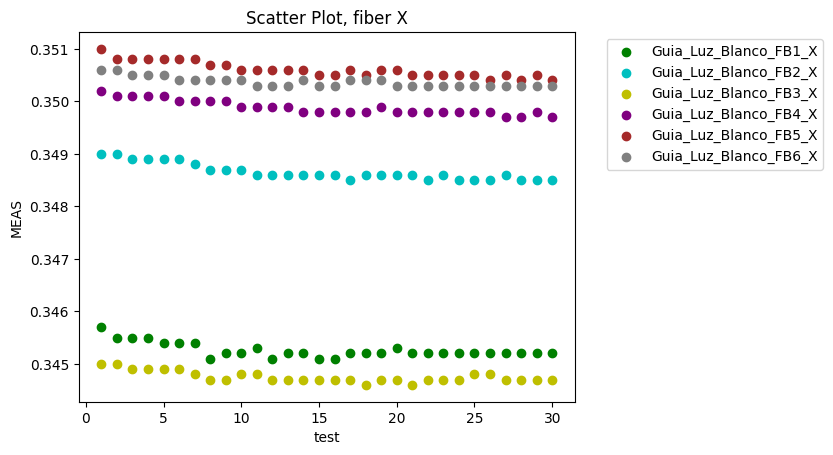

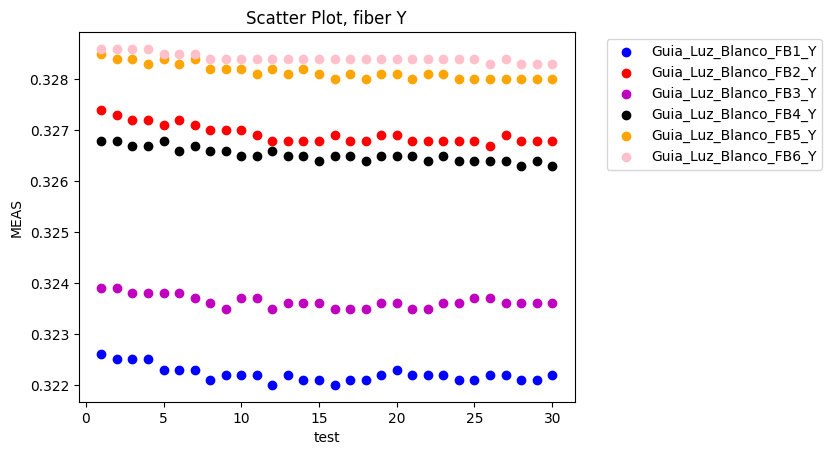

In [6]:
##Filtered data visualization
z_df = z_score_filter(pd.concat([MEAS, LIMITS], axis=1), 1000) #Huge numbers to disable
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', filter='x')
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber Y', 'test', 'MEAS', filter='y')

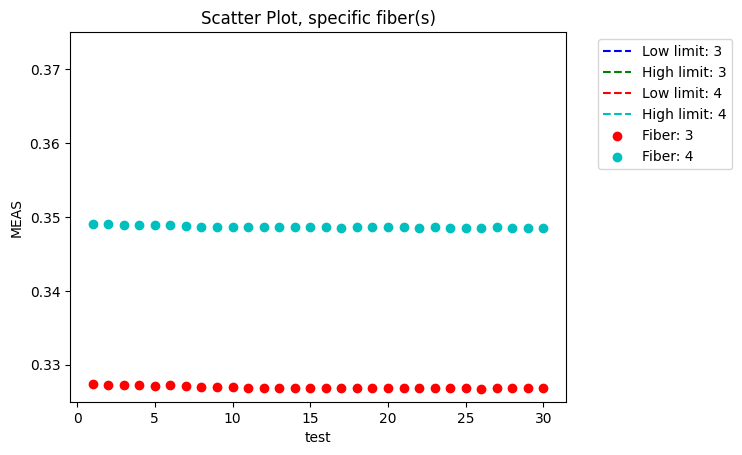

In [7]:
##Specific fibers visualization
if auto_position.value is False:
    range_mapping = [0.05 - 0.005 * (range_slider.value)]
    yrange = [mean_slider.value - range_mapping[0], mean_slider.value + range_mapping[0]]
else:
    range_mapping = None; yrange = None
display(HBox([auto_position, mean_slider, range_slider]))
plot_scatter(MEAS, title='Scatter Plot, specific fiber(s)', xlabel='test', ylabel='MEAS', limits=LIMITS, filter=[3, 4], yrange=yrange)

In [8]:
##Filtered data review
z_df_format = rename_index(z_df)
z_df_format.columns = [f"Test: {i}" for i in range(1, z_df_format.shape[1]-1)] + ["LSL", "USL"]
z_df_format

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 23,Test: 24,Test: 25,Test: 26,Test: 27,Test: 28,Test: 29,Test: 30,LSL,USL
Guia_Luz_Blanco_FB1_X,0.3226,0.3225,0.3225,0.3225,0.3223,0.3223,0.3223,0.3221,0.3222,0.3222,...,0.3222,0.3221,0.3221,0.3222,0.3222,0.3221,0.3221,0.3222,0.1,0.4
Guia_Luz_Blanco_FB1_Y,0.3457,0.3455,0.3455,0.3455,0.3454,0.3454,0.3454,0.3451,0.3452,0.3452,...,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.1,0.4
Guia_Luz_Blanco_FB2_X,0.3274,0.3273,0.3272,0.3272,0.3271,0.3272,0.3271,0.3270,0.3270,0.3270,...,0.3268,0.3268,0.3268,0.3267,0.3269,0.3268,0.3268,0.3268,0.1,0.4
Guia_Luz_Blanco_FB2_Y,0.3490,0.3490,0.3489,0.3489,0.3489,0.3489,0.3488,0.3487,0.3487,0.3487,...,0.3486,0.3485,0.3485,0.3485,0.3486,0.3485,0.3485,0.3485,0.1,0.4
Guia_Luz_Blanco_FB3_X,0.3239,0.3239,0.3238,0.3238,0.3238,0.3238,0.3237,0.3236,0.3235,0.3237,...,0.3236,0.3236,0.3237,0.3237,0.3236,0.3236,0.3236,0.3236,0.1,0.4
Guia_Luz_Blanco_FB3_Y,0.3450,0.3450,0.3449,0.3449,0.3449,0.3449,0.3448,0.3447,0.3447,0.3448,...,0.3447,0.3447,0.3448,0.3448,0.3447,0.3447,0.3447,0.3447,0.1,0.4
Guia_Luz_Blanco_FB4_X,0.3268,0.3268,0.3267,0.3267,0.3268,0.3266,0.3267,0.3266,0.3266,0.3265,...,0.3265,0.3264,0.3264,0.3264,0.3264,0.3263,0.3264,0.3263,0.1,0.4
Guia_Luz_Blanco_FB4_Y,0.3502,0.3501,0.3501,0.3501,0.3501,0.3500,0.3500,0.3500,0.3500,0.3499,...,0.3498,0.3498,0.3498,0.3498,0.3497,0.3497,0.3498,0.3497,0.1,0.4
Guia_Luz_Blanco_FB5_X,0.3285,0.3284,0.3284,0.3283,0.3284,0.3283,0.3284,0.3282,0.3282,0.3282,...,0.3281,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.1,0.4
Guia_Luz_Blanco_FB5_Y,0.3510,0.3508,0.3508,0.3508,0.3508,0.3508,0.3508,0.3507,0.3507,0.3506,...,0.3505,0.3505,0.3505,0.3504,0.3505,0.3504,0.3505,0.3504,0.1,0.4


In [9]:
##Filtered RyR generation
RyR_df = RyR(z_df)
RyR_df_format = rename_index(RyR_df)
print("RyR filtered")
RyR_df_format

RyR filtered


,RyR,Status
Guia_Luz_Blanco_FB1_X,0.295872,Correct
Guia_Luz_Blanco_FB1_Y,0.285754,Correct
Guia_Luz_Blanco_FB2_X,0.360651,Correct
Guia_Luz_Blanco_FB2_Y,0.318112,Correct
Guia_Luz_Blanco_FB3_X,0.238385,Correct
Guia_Luz_Blanco_FB3_Y,0.208001,Correct
Guia_Luz_Blanco_FB4_X,0.281294,Correct
Guia_Luz_Blanco_FB4_Y,0.271564,Correct
Guia_Luz_Blanco_FB5_X,0.305129,Correct
Guia_Luz_Blanco_FB5_Y,0.296803,Correct


In [10]:
##Update of the database
name = re.sub(r'\W', '_', glob.tooling + "_" + get_date()) + "_measurements&filtered"
confirmation = input("Do you want to export the new limits to your database (y/n): ").strip().lower()
if confirmation == 'y':
    prepare_database("input.db", z_df.iloc[:, :-2], name) #Store a df for the limits inside the database of the project
    limits_file = rename_limits_table("output.db", name)
    print("Limit files renamed for clarity.")
    consult_database("input.db", verbose=True)
else:
    print("Operation canceled.")

Operation canceled.
